In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
import pandas as pd

In [3]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [4]:
data = np.load("/kaggle/input/datasetcleaned/mars_for_students.npz")

In [5]:
X = np.load('/kaggle/input/datasetcleaned/X.npy')
y = np.load('/kaggle/input/datasetcleaned/y.npy')
X_test = data["test_set"]

In [6]:
import albumentations as A
aug = A.Compose(
    [
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=0.8)
    ]
)

In [7]:
for i in range(len(X)):
    if np.any(y[i] == 4):
        temp = aug(image = X[i], mask = y[i])
        temp_image = np.expand_dims(temp['image'], axis=0)  # Add a batch dimension
        temp_mask = np.expand_dims(temp['mask'], axis=0)    # Add a batch dimension

        
        X = np.concatenate((X, temp_image), axis=0)
        y = np.concatenate((y, temp_mask), axis=0)
        print(X.shape)



(2506, 64, 128)
(2507, 64, 128)
(2508, 64, 128)
(2509, 64, 128)
(2510, 64, 128)
(2511, 64, 128)
(2512, 64, 128)
(2513, 64, 128)
(2514, 64, 128)
(2515, 64, 128)
(2516, 64, 128)
(2517, 64, 128)
(2518, 64, 128)
(2519, 64, 128)
(2520, 64, 128)
(2521, 64, 128)
(2522, 64, 128)
(2523, 64, 128)
(2524, 64, 128)
(2525, 64, 128)
(2526, 64, 128)
(2527, 64, 128)
(2528, 64, 128)
(2529, 64, 128)
(2530, 64, 128)
(2531, 64, 128)
(2532, 64, 128)
(2533, 64, 128)
(2534, 64, 128)
(2535, 64, 128)
(2536, 64, 128)
(2537, 64, 128)
(2538, 64, 128)
(2539, 64, 128)
(2540, 64, 128)
(2541, 64, 128)
(2542, 64, 128)
(2543, 64, 128)
(2544, 64, 128)
(2545, 64, 128)
(2546, 64, 128)
(2547, 64, 128)
(2548, 64, 128)
(2549, 64, 128)
(2550, 64, 128)
(2551, 64, 128)
(2552, 64, 128)
(2553, 64, 128)
(2554, 64, 128)
(2555, 64, 128)
(2556, 64, 128)
(2557, 64, 128)
(2558, 64, 128)
(2559, 64, 128)
(2560, 64, 128)
(2561, 64, 128)
(2562, 64, 128)
(2563, 64, 128)
(2564, 64, 128)
(2565, 64, 128)
(2566, 64, 128)
(2567, 64, 128)
(2568, 6

In [8]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val,y_train, y_val = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train = (X_train[..., np.newaxis]) / 255.0
X_val = (X_val[..., np.newaxis]) / 255.0
X_test = (X_test[..., np.newaxis])/ 255.0
print("Data splitted!")
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)
print(X_test.shape)

Splitting data...
Data splitted!
X_train: (2054, 64, 128, 1) y_train: (2054, 64, 128) X_val: (514, 64, 128, 1) y_val: (514, 64, 128)
(10022, 64, 128, 1)


In [9]:
print(X_test.shape)

(10022, 64, 128, 1)


In [10]:
#Compute and adjust class weights
cw =compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train.flatten())
print(cw)
cw[0] = 0.0
print(cw)

[ 0.80921074  0.60725697  0.85744741  1.0654779  78.86189394]
[ 0.          0.60725697  0.85744741  1.0654779  78.86189394]


In [11]:
 category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4}  # Big Rock
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [12]:
def load_single_image(image, label, input_size=(64, 128)):
    
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [13]:
def apply_category_mapping(label):
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [14]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [15]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'int32'>


In [16]:
def gate(e,d,filters):
    a = tfkl.Add()([e, d])
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(a)
    x = tfkl.Activation(activation="sigmoid")(x)
    b = tfkl.Multiply()([x, e])
    out = tfkl.Add()([a, b])
    return x

In [17]:
def unet_block(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor
    residual_tot = input_tensor  # Store the input as residual

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        residual = x  # Store the input as residual
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = tfkl.GroupNormalization(groups=16)(x)
        x = tfkl.Activation(activation)(x)

        # Match the dimensions of residual to x if they differ
        if residual.shape[-1] != filters:
            residual = tfkl.Conv2D(filters, kernel_size=1, padding='same')(residual)
    
        # Add residual connection
        x = tfkl.Add()([x, residual])
    if residual_tot.shape[-1] != filters:
            residual_tot = tfkl.Conv2D(filters, kernel_size=1, padding='same')(residual_tot)
    x = tfkl.Add()([x, residual_tot])
    # Return the transformed tensor
    return x


def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck 
    bottleneck = unet_block(d2, 128)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    x = unet_block(down_block_2, 128)
    u1 = gate(u1, x, 128)
    u1 = unet_block(u1, 64)

    u2 = tfkl.UpSampling2D()(u1)
    y = unet_block(down_block_1, 64)
    u2 = gate(u2, y, 64)
    u2 = unet_block(u2, 32)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_Attention')
    return model


In [18]:

model = get_unet_model(input_shape=input_shape, num_classes=NUM_CLASSES)
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet_with_Attention"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d[0][0]   │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 64, 128, │         0 │ activation[0]… │   -   │
│                   │ 32)             │           │ conv2d_1[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ add[0][0]      │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d_2[0][0] │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_1 (Add)       │ (None, 64, 128, │         0 │ activation_1[… │   -   │
│                   │ 32)             │           │ add[0][0]      │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_2 (Add)       │ (None, 64, 128, │         0 │ add_1[0][0],   │   -   │
│                   │ 32)             │           │ conv2d_3[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ add_2[0][0]    │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 32, 64,  │       128 │ conv2d_4[0][0] │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ group_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_5 (Conv2D) │ (None, 32, 64,  │     2,112 │ max_pooling2d… │   Y 

 Total params: 787,141 (3.00 MB)

 Trainable params: 787,141 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [20]:
import tensorflow.keras.backend as K

def focal_lossw(alpha=0.25, gamma=2.0, class_weights=None):
    def loss(y_true, y_pred):
        # Ensure y_true is one-hot encoded if not already
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute the focal loss scaling factor
        scaling_factor = tf.pow(1 - y_pred, gamma)

        # Apply the focal loss formula
        focal_loss = alpha * scaling_factor * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights to tensor
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            # Multiply the loss for each class by its weight
            focal_loss *= tf.expand_dims(tf.reduce_sum(y_true * class_weights_tensor, axis=-1), axis=-1)

        # Reduce the loss across spatial and class dimensions
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

focal = focal_lossw(alpha=0.25, gamma=2.0,class_weights=cw)
# Compile the model
print("Compiling model...")
model.compile(
    loss=focal,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,    # Adjust based on your dataset and model
    weight_decay=1e-3      # High decay to regularize small batches
),
    metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

#Implement Learning Rate Reducing
lr_callback = ReduceLROnPlateau(
    monitor='val_mean_iou',  # Metric to monitor
    mode = 'max',
    factor=0.5,          # Reduce LR by 50%
    patience=10,          # Wait 10 epochs of no improvement
    verbose=1,           # Print updates
    min_lr=1e-6          # Lower bound on LR
)

Epoch 1/1000


I0000 00:00:1734192438.096748      90 service.cc:145] XLA service 0x7c3d9c011830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734192438.096826      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734192438.096835      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/129 ━━━━━━━━━━━━━━━━━━━━ 1:09:16 32s/step - loss: 0.6765 - mean_iou: 0.1003

I0000 00:00:1734192457.942396      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2157 - mean_iou: 0.1045

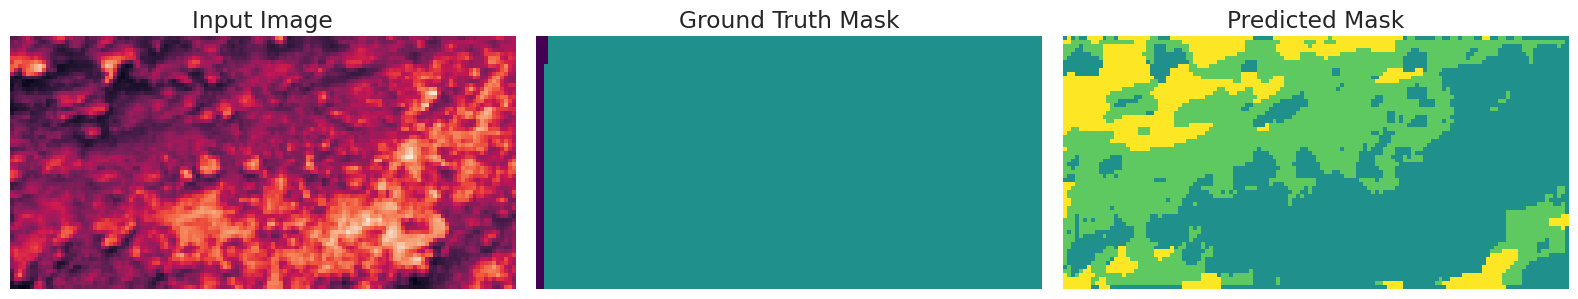

129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - loss: 0.2153 - mean_iou: 0.1047 - val_loss: 0.1307 - val_mean_iou: 0.1717 - learning_rate: 0.0010
Epoch 2/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.1209 - mean_iou: 0.2348 - val_loss: 0.0916 - val_mean_iou: 0.2232 - learning_rate: 0.0010
Epoch 3/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0912 - mean_iou: 0.3134 - val_loss: 0.0724 - val_mean_iou: 0.3843 - learning_rate: 0.0010
Epoch 4/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0758 - mean_iou: 0.3798 - val_loss: 0.0644 - val_mean_iou: 0.4375 - learning_rate: 0.0010
Epoch 5/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0733 - mean_iou: 0.4047 - val_loss: 0.0697 - val_mean_iou: 0.3919 - learning_rate: 0.0010
Epoch 6/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0723 - mean_iou: 0.3989

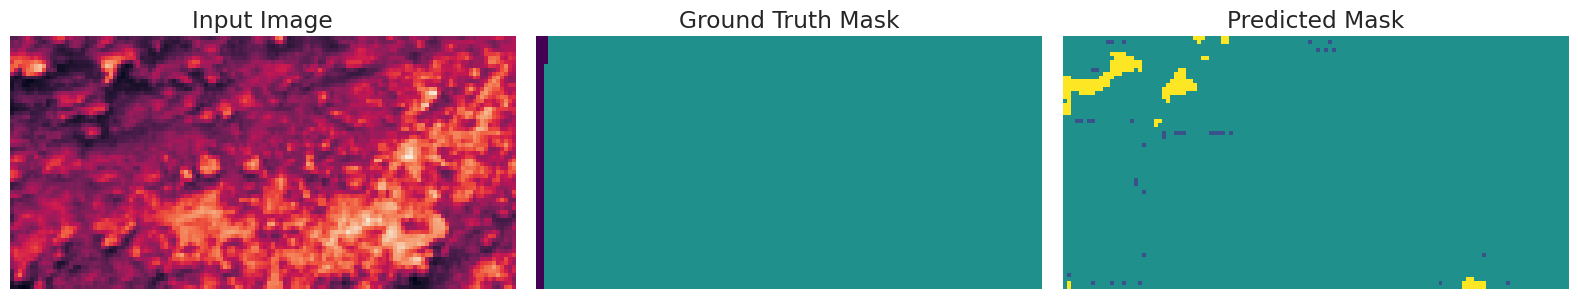

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0723 - mean_iou: 0.3991 - val_loss: 0.0656 - val_mean_iou: 0.4206 - learning_rate: 0.0010
Epoch 7/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0745 - mean_iou: 0.4042 - val_loss: 0.0577 - val_mean_iou: 0.4585 - learning_rate: 0.0010
Epoch 8/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0610 - mean_iou: 0.4373 - val_loss: 0.0567 - val_mean_iou: 0.4423 - learning_rate: 0.0010
Epoch 9/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0618 - mean_iou: 0.4300 - val_loss: 0.0547 - val_mean_iou: 0.4463 - learning_rate: 0.0010
Epoch 10/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0569 - mean_iou: 0.4531 - val_loss: 0.0544 - val_mean_iou: 0.4710 - learning_rate: 0.0010
Epoch 11/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0564 - mean_iou: 0.4573

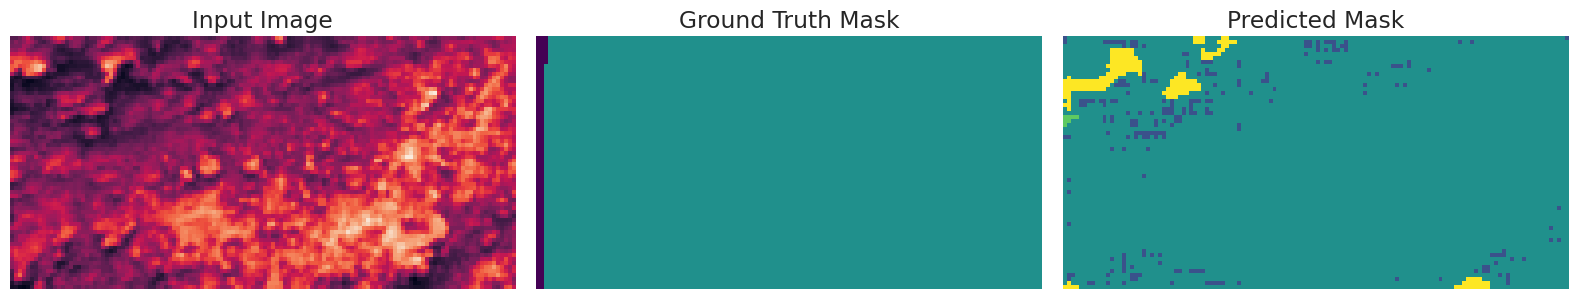

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0564 - mean_iou: 0.4574 - val_loss: 0.0573 - val_mean_iou: 0.4363 - learning_rate: 0.0010
Epoch 12/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0615 - mean_iou: 0.4251 - val_loss: 0.0640 - val_mean_iou: 0.4206 - learning_rate: 0.0010
Epoch 13/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0582 - mean_iou: 0.4435 - val_loss: 0.0631 - val_mean_iou: 0.3904 - learning_rate: 0.0010
Epoch 14/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0656 - mean_iou: 0.4086 - val_loss: 0.0480 - val_mean_iou: 0.4872 - learning_rate: 0.0010
Epoch 15/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0509 - mean_iou: 0.4818 - val_loss: 0.0474 - val_mean_iou: 0.4898 - learning_rate: 0.0010
Epoch 16/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0519 - mean_iou: 0.4813

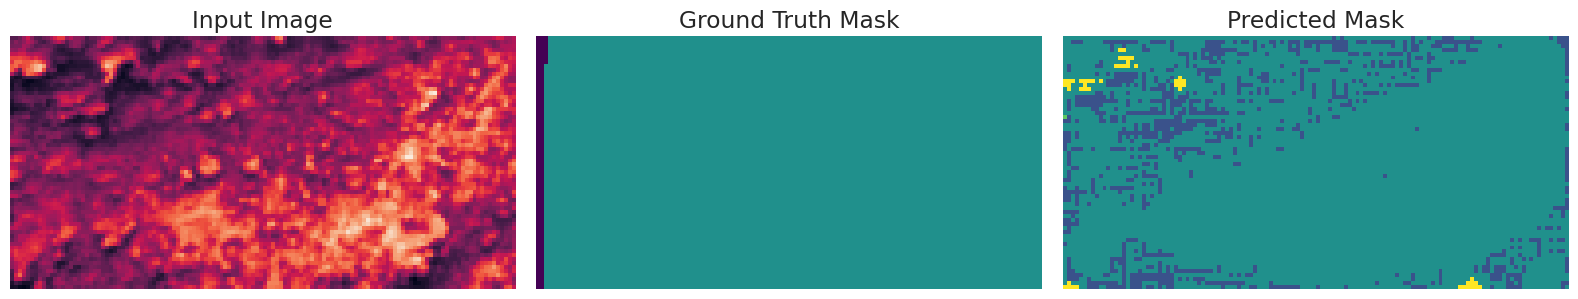

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0518 - mean_iou: 0.4814 - val_loss: 0.0488 - val_mean_iou: 0.4853 - learning_rate: 0.0010
Epoch 17/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0450 - mean_iou: 0.4870 - val_loss: 0.0449 - val_mean_iou: 0.4996 - learning_rate: 0.0010
Epoch 18/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0493 - mean_iou: 0.4892 - val_loss: 0.0460 - val_mean_iou: 0.4954 - learning_rate: 0.0010
Epoch 19/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0446 - mean_iou: 0.4940 - val_loss: 0.0509 - val_mean_iou: 0.4663 - learning_rate: 0.0010
Epoch 20/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0429 - mean_iou: 0.5033 - val_loss: 0.0478 - val_mean_iou: 0.5019 - learning_rate: 0.0010
Epoch 21/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0404 - mean_iou: 0.5158

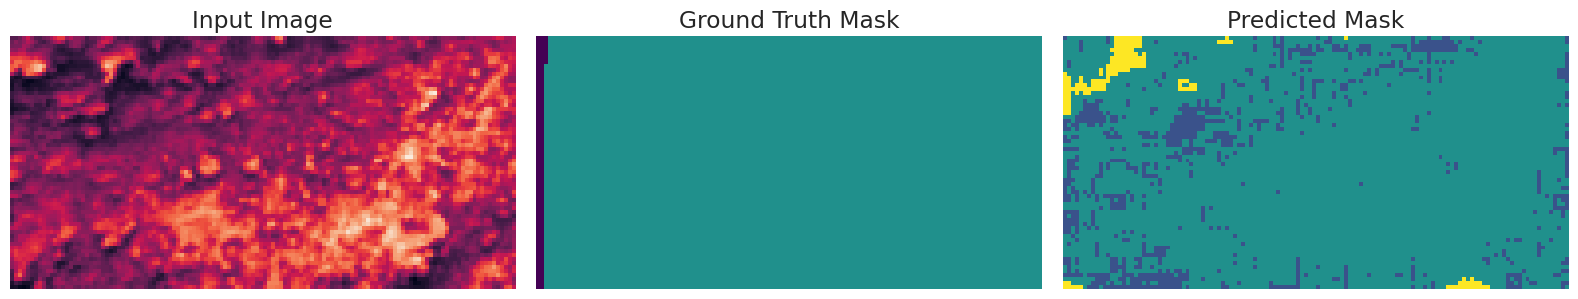

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0404 - mean_iou: 0.5158 - val_loss: 0.0524 - val_mean_iou: 0.5005 - learning_rate: 0.0010
Epoch 22/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0443 - mean_iou: 0.4995 - val_loss: 0.0429 - val_mean_iou: 0.5035 - learning_rate: 0.0010
Epoch 23/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0596 - mean_iou: 0.4794 - val_loss: 0.0480 - val_mean_iou: 0.4714 - learning_rate: 0.0010
Epoch 24/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0397 - mean_iou: 0.5181 - val_loss: 0.0447 - val_mean_iou: 0.5190 - learning_rate: 0.0010
Epoch 25/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0373 - mean_iou: 0.5339 - val_loss: 0.0453 - val_mean_iou: 0.5011 - learning_rate: 0.0010
Epoch 26/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0366 - mean_iou: 0.5375

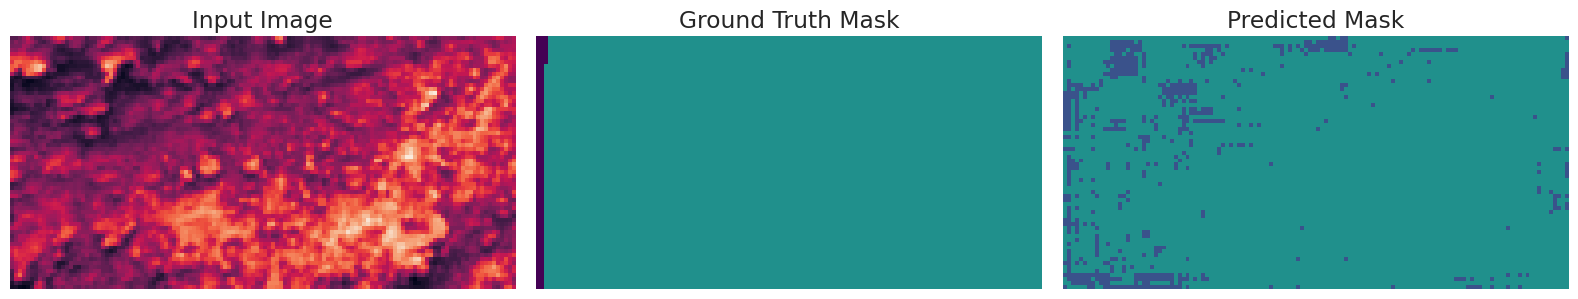

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0366 - mean_iou: 0.5376 - val_loss: 0.0449 - val_mean_iou: 0.5412 - learning_rate: 0.0010
Epoch 27/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0326 - mean_iou: 0.5458 - val_loss: 0.0481 - val_mean_iou: 0.5280 - learning_rate: 0.0010
Epoch 28/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0335 - mean_iou: 0.5553 - val_loss: 0.0421 - val_mean_iou: 0.5319 - learning_rate: 0.0010
Epoch 29/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0309 - mean_iou: 0.5584 - val_loss: 0.0408 - val_mean_iou: 0.5617 - learning_rate: 0.0010
Epoch 30/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0291 - mean_iou: 0.5672 - val_loss: 0.0451 - val_mean_iou: 0.5025 - learning_rate: 0.0010
Epoch 31/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0306 - mean_iou: 0.5505

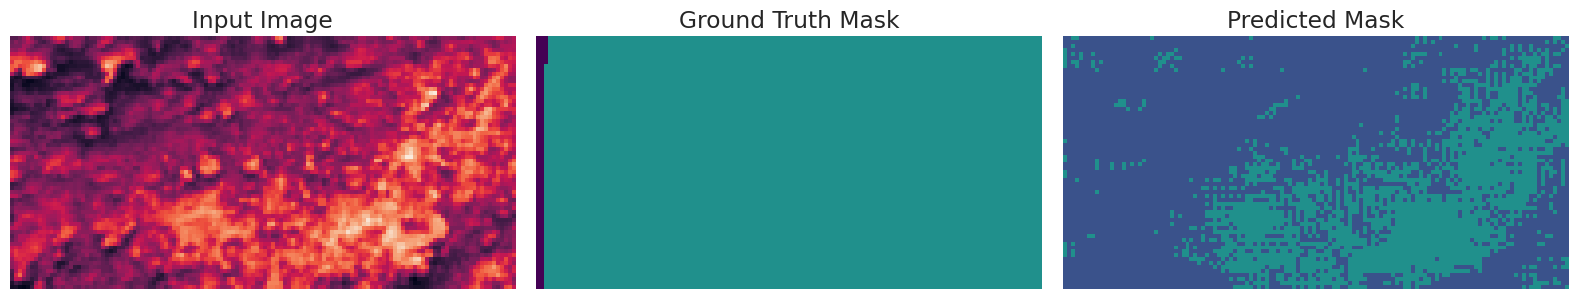

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0306 - mean_iou: 0.5507 - val_loss: 0.0435 - val_mean_iou: 0.5596 - learning_rate: 0.0010
Epoch 32/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0268 - mean_iou: 0.5801 - val_loss: 0.0477 - val_mean_iou: 0.5512 - learning_rate: 0.0010
Epoch 33/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0274 - mean_iou: 0.5873 - val_loss: 0.0389 - val_mean_iou: 0.5454 - learning_rate: 0.0010
Epoch 34/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0288 - mean_iou: 0.5685 - val_loss: 0.0371 - val_mean_iou: 0.5770 - learning_rate: 0.0010
Epoch 35/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0326 - mean_iou: 0.5776 - val_loss: 0.0613 - val_mean_iou: 0.4624 - learning_rate: 0.0010
Epoch 36/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0294 - mean_iou: 0.5630

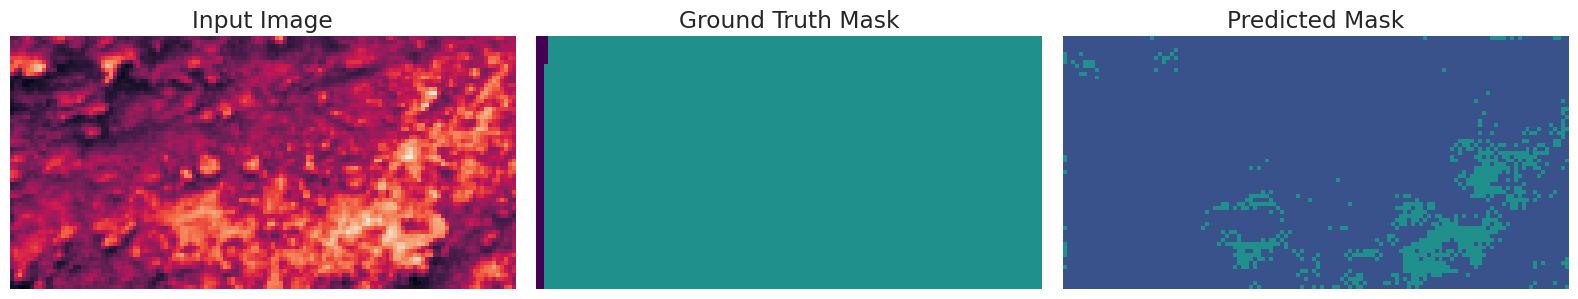

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0294 - mean_iou: 0.5633 - val_loss: 0.0422 - val_mean_iou: 0.5746 - learning_rate: 0.0010
Epoch 37/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0262 - mean_iou: 0.5881 - val_loss: 0.0505 - val_mean_iou: 0.5602 - learning_rate: 0.0010
Epoch 38/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0277 - mean_iou: 0.5831 - val_loss: 0.0494 - val_mean_iou: 0.5501 - learning_rate: 0.0010
Epoch 39/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0360 - mean_iou: 0.5508 - val_loss: 0.0431 - val_mean_iou: 0.5455 - learning_rate: 0.0010
Epoch 40/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0349 - mean_iou: 0.5534 - val_loss: 0.0397 - val_mean_iou: 0.5796 - learning_rate: 0.0010
Epoch 41/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0251 - mean_iou: 0.6017

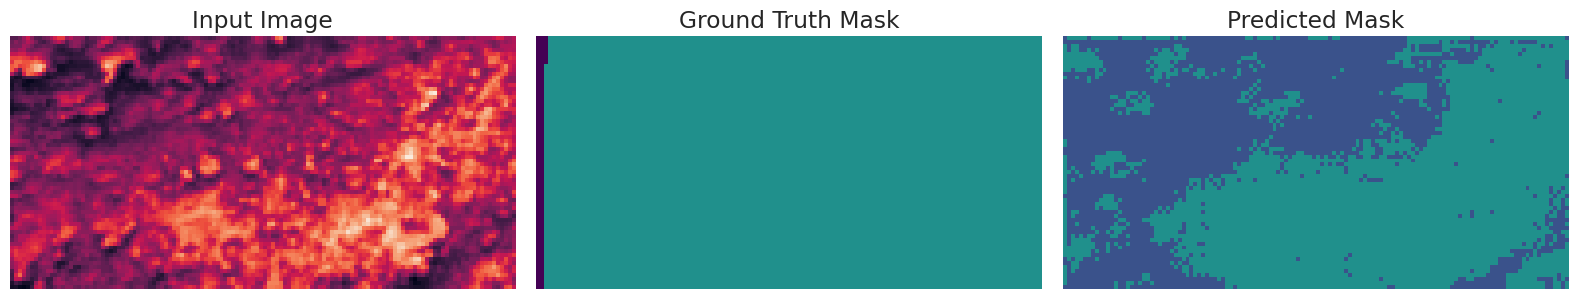

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0251 - mean_iou: 0.6015 - val_loss: 0.0433 - val_mean_iou: 0.5870 - learning_rate: 0.0010
Epoch 42/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0245 - mean_iou: 0.6006 - val_loss: 0.0388 - val_mean_iou: 0.5788 - learning_rate: 0.0010
Epoch 43/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0246 - mean_iou: 0.6002 - val_loss: 0.0464 - val_mean_iou: 0.5370 - learning_rate: 0.0010
Epoch 44/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0214 - mean_iou: 0.6072 - val_loss: 0.0425 - val_mean_iou: 0.5466 - learning_rate: 0.0010
Epoch 45/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0211 - mean_iou: 0.6102 - val_loss: 0.0600 - val_mean_iou: 0.4178 - learning_rate: 0.0010
Epoch 46/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0349 - mean_iou: 0.5302

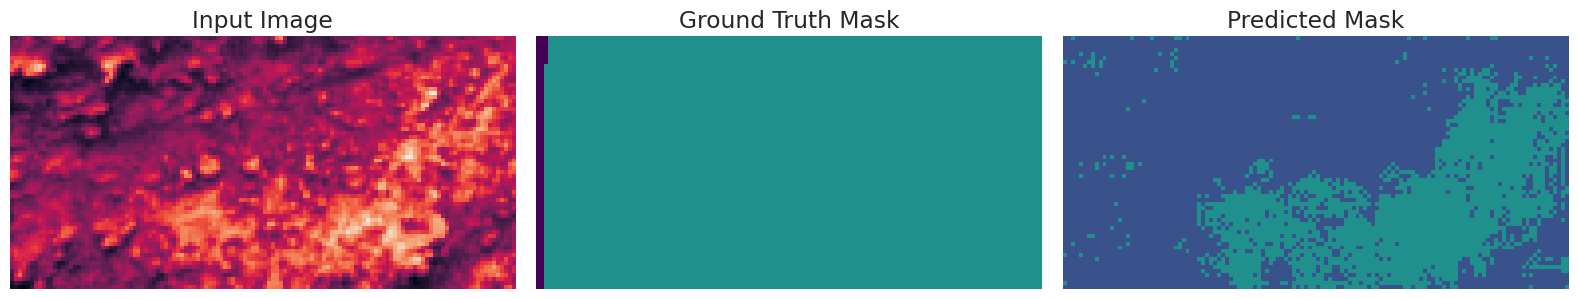

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0349 - mean_iou: 0.5305 - val_loss: 0.0401 - val_mean_iou: 0.5583 - learning_rate: 0.0010
Epoch 47/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0225 - mean_iou: 0.6052 - val_loss: 0.0429 - val_mean_iou: 0.5866 - learning_rate: 0.0010
Epoch 48/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0187 - mean_iou: 0.6355 - val_loss: 0.0487 - val_mean_iou: 0.5810 - learning_rate: 0.0010
Epoch 49/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0189 - mean_iou: 0.6403 - val_loss: 0.0512 - val_mean_iou: 0.5951 - learning_rate: 0.0010
Epoch 50/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0175 - mean_iou: 0.6502 - val_loss: 0.0669 - val_mean_iou: 0.5698 - learning_rate: 0.0010
Epoch 51/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0199 - mean_iou: 0.6298

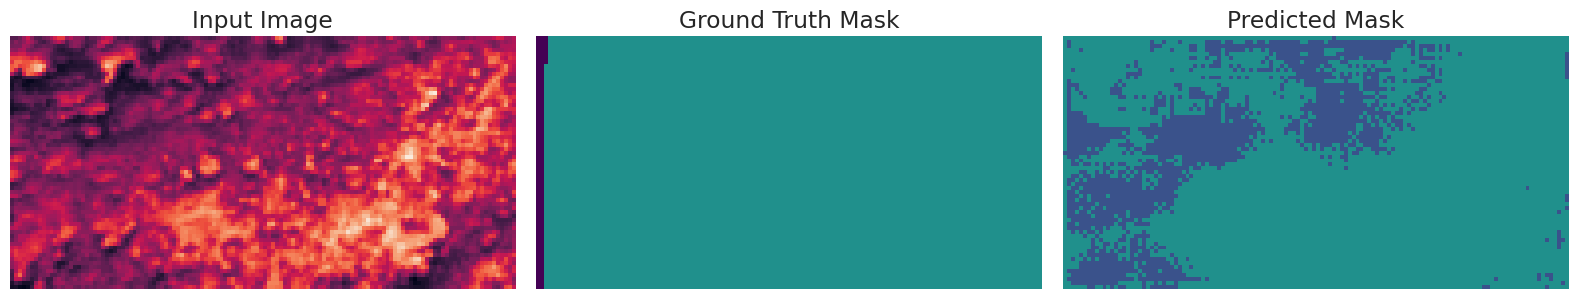

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0199 - mean_iou: 0.6297 - val_loss: 0.0355 - val_mean_iou: 0.5751 - learning_rate: 0.0010
Epoch 52/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0196 - mean_iou: 0.6311 - val_loss: 0.0478 - val_mean_iou: 0.6006 - learning_rate: 0.0010
Epoch 53/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0175 - mean_iou: 0.6533 - val_loss: 0.0430 - val_mean_iou: 0.6154 - learning_rate: 0.0010
Epoch 54/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0187 - mean_iou: 0.6517 - val_loss: 0.0609 - val_mean_iou: 0.5576 - learning_rate: 0.0010
Epoch 55/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0305 - mean_iou: 0.5859 - val_loss: 0.0444 - val_mean_iou: 0.5867 - learning_rate: 0.0010
Epoch 56/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0246 - mean_iou: 0.6132

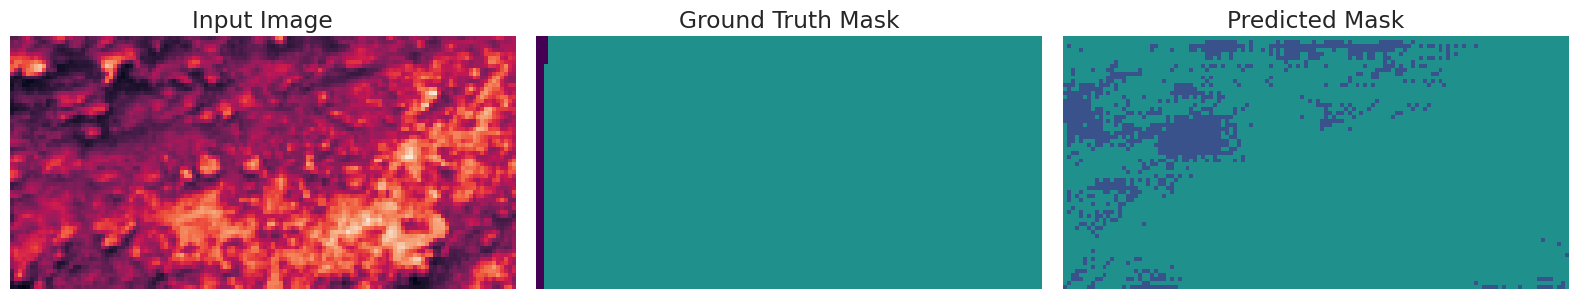

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0246 - mean_iou: 0.6133 - val_loss: 0.0359 - val_mean_iou: 0.5854 - learning_rate: 0.0010
Epoch 57/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0208 - mean_iou: 0.6224 - val_loss: 0.0406 - val_mean_iou: 0.6047 - learning_rate: 0.0010
Epoch 58/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0160 - mean_iou: 0.6626 - val_loss: 0.0448 - val_mean_iou: 0.5999 - learning_rate: 0.0010
Epoch 59/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0151 - mean_iou: 0.6743 - val_loss: 0.0418 - val_mean_iou: 0.6131 - learning_rate: 0.0010
Epoch 60/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0188 - mean_iou: 0.6366 - val_loss: 0.0387 - val_mean_iou: 0.6062 - learning_rate: 0.0010
Epoch 61/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0314 - mean_iou: 0.5913

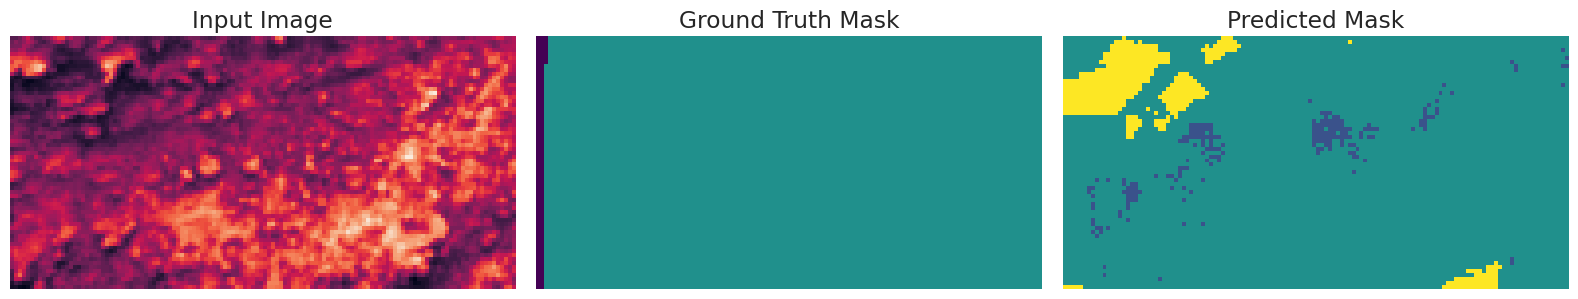

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0315 - mean_iou: 0.5910 - val_loss: 0.0512 - val_mean_iou: 0.5138 - learning_rate: 0.0010
Epoch 62/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0396 - mean_iou: 0.5472 - val_loss: 0.0350 - val_mean_iou: 0.5550 - learning_rate: 0.0010
Epoch 63/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0226 - mean_iou: 0.6118
Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0226 - mean_iou: 0.6121 - val_loss: 0.0349 - val_mean_iou: 0.5955 - learning_rate: 0.0010
Epoch 64/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0153 - mean_iou: 0.6738 - val_loss: 0.0331 - val_mean_iou: 0.6189 - learning_rate: 5.0000e-04
Epoch 65/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0132 - mean_iou: 0.6907 - val_loss: 0.0328 - val_mean_iou: 0.6243 - learning_rate: 5.0000e-04
Epoch 66/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.01

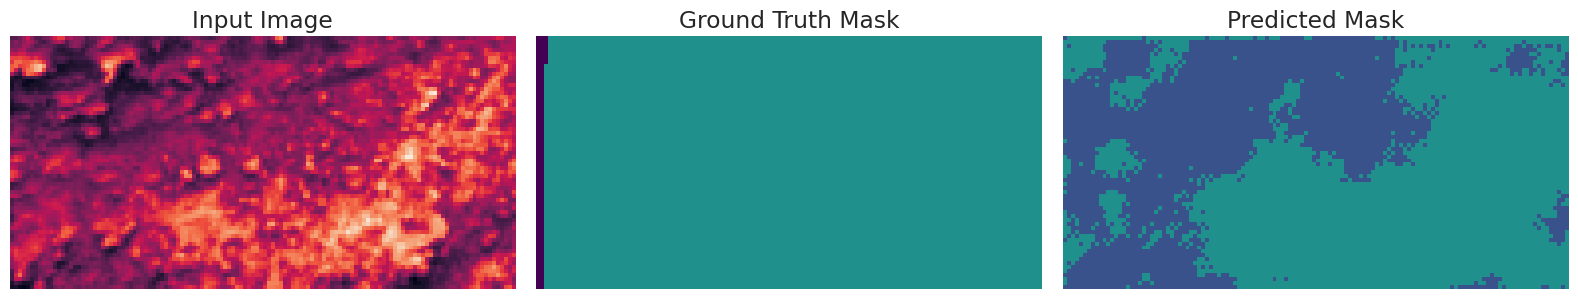

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0122 - mean_iou: 0.7067 - val_loss: 0.0335 - val_mean_iou: 0.6229 - learning_rate: 5.0000e-04
Epoch 67/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0118 - mean_iou: 0.7086 - val_loss: 0.0340 - val_mean_iou: 0.6325 - learning_rate: 5.0000e-04
Epoch 68/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0111 - mean_iou: 0.7191 - val_loss: 0.0352 - val_mean_iou: 0.6349 - learning_rate: 5.0000e-04
Epoch 69/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0110 - mean_iou: 0.7205 - val_loss: 0.0396 - val_mean_iou: 0.6246 - learning_rate: 5.0000e-04
Epoch 70/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0105 - mean_iou: 0.7313 - val_loss: 0.0347 - val_mean_iou: 0.6247 - learning_rate: 5.0000e-04
Epoch 71/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0104 - mean_iou: 0.7304

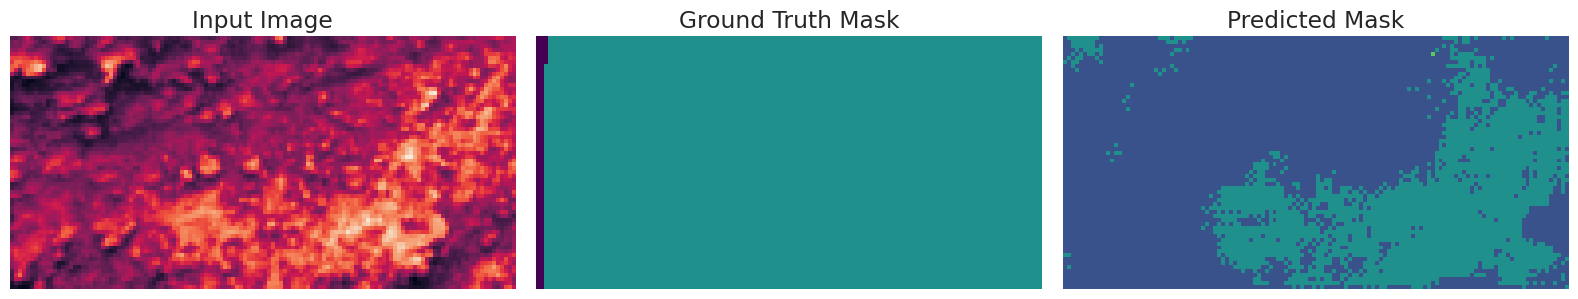

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0104 - mean_iou: 0.7304 - val_loss: 0.0385 - val_mean_iou: 0.6353 - learning_rate: 5.0000e-04
Epoch 72/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0098 - mean_iou: 0.7398 - val_loss: 0.0363 - val_mean_iou: 0.6409 - learning_rate: 5.0000e-04
Epoch 73/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0096 - mean_iou: 0.7463 - val_loss: 0.0366 - val_mean_iou: 0.6386 - learning_rate: 5.0000e-04
Epoch 74/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0092 - mean_iou: 0.7508 - val_loss: 0.0380 - val_mean_iou: 0.6453 - learning_rate: 5.0000e-04
Epoch 75/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0095 - mean_iou: 0.7396 - val_loss: 0.0468 - val_mean_iou: 0.6540 - learning_rate: 5.0000e-04
Epoch 76/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0100 - mean_iou: 0.7452

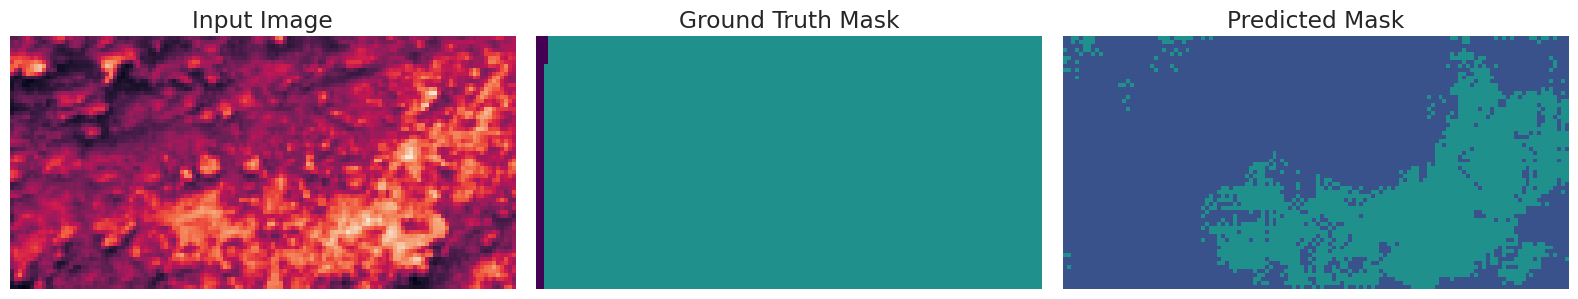

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0100 - mean_iou: 0.7451 - val_loss: 0.0432 - val_mean_iou: 0.6484 - learning_rate: 5.0000e-04
Epoch 77/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0095 - mean_iou: 0.7424 - val_loss: 0.0410 - val_mean_iou: 0.6403 - learning_rate: 5.0000e-04
Epoch 78/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0086 - mean_iou: 0.7593 - val_loss: 0.0386 - val_mean_iou: 0.6419 - learning_rate: 5.0000e-04
Epoch 79/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0090 - mean_iou: 0.7407 - val_loss: 0.0430 - val_mean_iou: 0.6511 - learning_rate: 5.0000e-04
Epoch 80/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0081 - mean_iou: 0.7752 - val_loss: 0.0417 - val_mean_iou: 0.6485 - learning_rate: 5.0000e-04
Epoch 81/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0077 - mean_iou: 0.7768

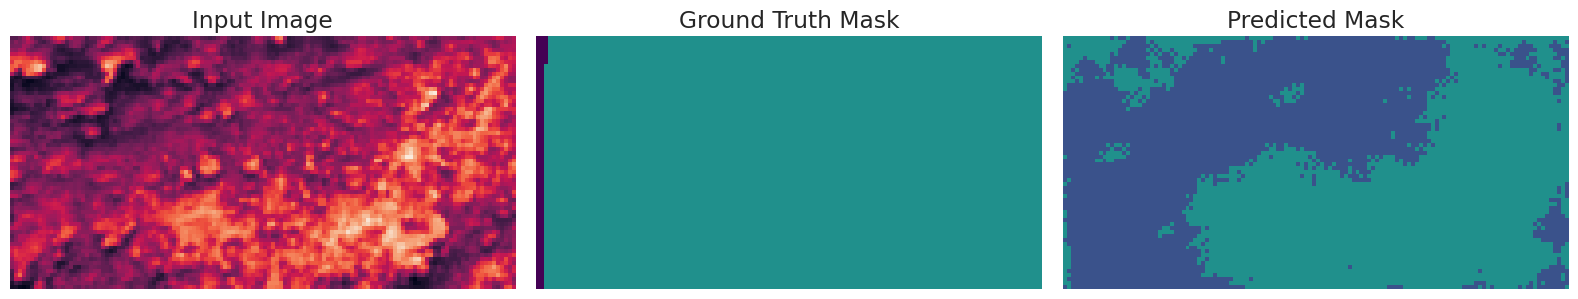

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0077 - mean_iou: 0.7768 - val_loss: 0.0468 - val_mean_iou: 0.6529 - learning_rate: 5.0000e-04
Epoch 82/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0081 - mean_iou: 0.7782 - val_loss: 0.0518 - val_mean_iou: 0.6616 - learning_rate: 5.0000e-04
Epoch 83/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0073 - mean_iou: 0.7962 - val_loss: 0.0499 - val_mean_iou: 0.6597 - learning_rate: 5.0000e-04
Epoch 84/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0070 - mean_iou: 0.8014 - val_loss: 0.0474 - val_mean_iou: 0.6353 - learning_rate: 5.0000e-04
Epoch 85/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0127 - mean_iou: 0.7096 - val_loss: 0.0416 - val_mean_iou: 0.6461 - learning_rate: 5.0000e-04
Epoch 86/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0087 - mean_iou: 0.7624

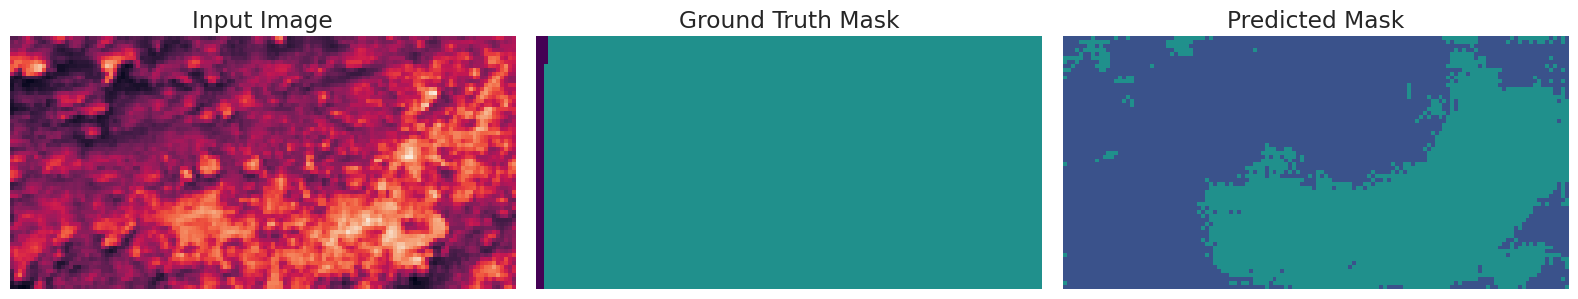

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0087 - mean_iou: 0.7623 - val_loss: 0.0423 - val_mean_iou: 0.6514 - learning_rate: 5.0000e-04
Epoch 87/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0071 - mean_iou: 0.7978 - val_loss: 0.0429 - val_mean_iou: 0.6468 - learning_rate: 5.0000e-04
Epoch 88/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0106 - mean_iou: 0.7188 - val_loss: 0.0497 - val_mean_iou: 0.6028 - learning_rate: 5.0000e-04
Epoch 89/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0098 - mean_iou: 0.7438 - val_loss: 0.0452 - val_mean_iou: 0.6505 - learning_rate: 5.0000e-04
Epoch 90/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0071 - mean_iou: 0.7941 - val_loss: 0.0463 - val_mean_iou: 0.6454 - learning_rate: 5.0000e-04
Epoch 91/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0071 - mean_iou: 0.7972

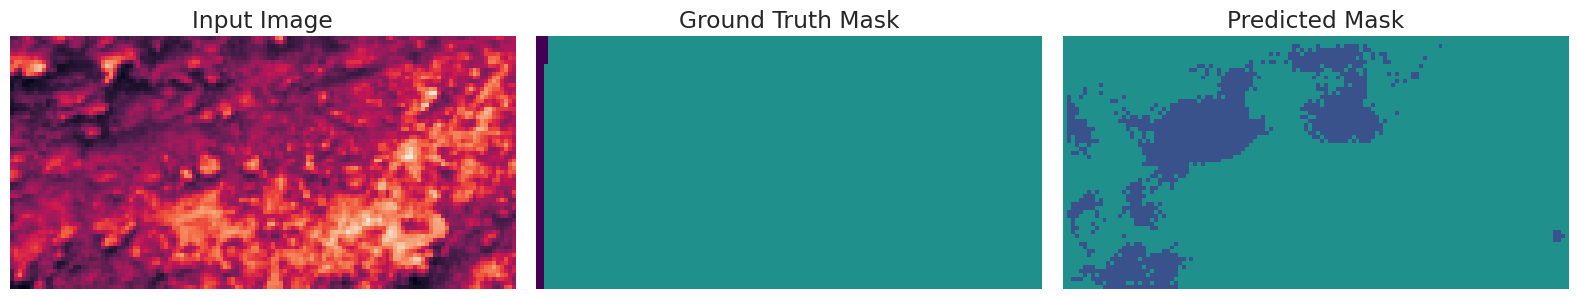

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0071 - mean_iou: 0.7971 - val_loss: 0.0486 - val_mean_iou: 0.6206 - learning_rate: 5.0000e-04
Epoch 92/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0065 - mean_iou: 0.8187 - val_loss: 0.0543 - val_mean_iou: 0.6663 - learning_rate: 5.0000e-04
Epoch 93/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0056 - mean_iou: 0.8491 - val_loss: 0.0564 - val_mean_iou: 0.6701 - learning_rate: 5.0000e-04
Epoch 94/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0055 - mean_iou: 0.8478 - val_loss: 0.0604 - val_mean_iou: 0.6575 - learning_rate: 5.0000e-04
Epoch 95/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0059 - mean_iou: 0.8379 - val_loss: 0.0599 - val_mean_iou: 0.6623 - learning_rate: 5.0000e-04
Epoch 96/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0056 - mean_iou: 0.8389

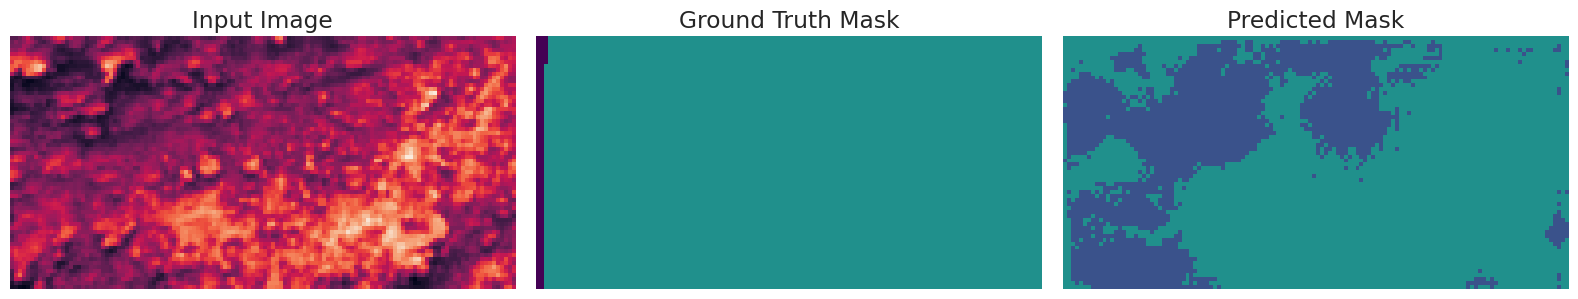

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0056 - mean_iou: 0.8390 - val_loss: 0.0635 - val_mean_iou: 0.6499 - learning_rate: 5.0000e-04
Epoch 97/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0052 - mean_iou: 0.8582 - val_loss: 0.0595 - val_mean_iou: 0.6740 - learning_rate: 5.0000e-04
Epoch 98/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0057 - mean_iou: 0.8565 - val_loss: 0.0632 - val_mean_iou: 0.6284 - learning_rate: 5.0000e-04
Epoch 99/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0152 - mean_iou: 0.6881 - val_loss: 0.0387 - val_mean_iou: 0.6167 - learning_rate: 5.0000e-04
Epoch 100/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0082 - mean_iou: 0.7560 - val_loss: 0.0424 - val_mean_iou: 0.6545 - learning_rate: 5.0000e-04
Epoch 101/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0057 - mean_iou: 0.8210

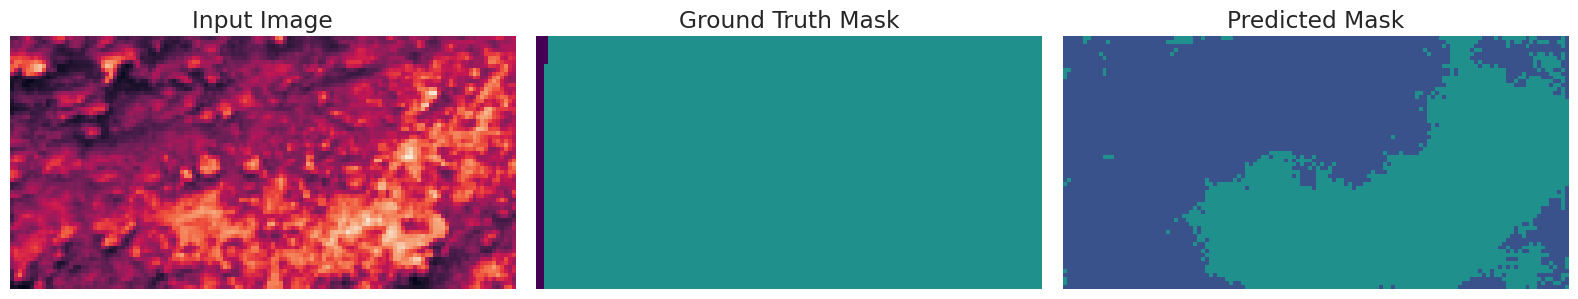

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0057 - mean_iou: 0.8211 - val_loss: 0.0493 - val_mean_iou: 0.6692 - learning_rate: 5.0000e-04
Epoch 102/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0050 - mean_iou: 0.8403 - val_loss: 0.0623 - val_mean_iou: 0.6602 - learning_rate: 5.0000e-04
Epoch 103/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0050 - mean_iou: 0.8618 - val_loss: 0.0603 - val_mean_iou: 0.6803 - learning_rate: 5.0000e-04
Epoch 104/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0047 - mean_iou: 0.8708 - val_loss: 0.0676 - val_mean_iou: 0.6701 - learning_rate: 5.0000e-04
Epoch 105/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0046 - mean_iou: 0.8756 - val_loss: 0.0655 - val_mean_iou: 0.6558 - learning_rate: 5.0000e-04
Epoch 106/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0044 - mean_iou: 0.8862

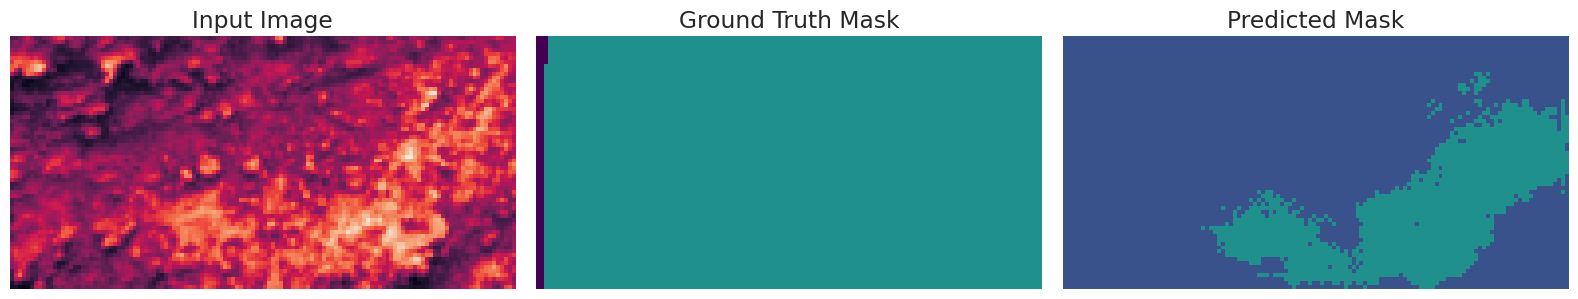

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0044 - mean_iou: 0.8861 - val_loss: 0.0676 - val_mean_iou: 0.6829 - learning_rate: 5.0000e-04
Epoch 107/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0048 - mean_iou: 0.8791 - val_loss: 0.0448 - val_mean_iou: 0.5974 - learning_rate: 5.0000e-04
Epoch 108/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0333 - mean_iou: 0.6048 - val_loss: 0.0332 - val_mean_iou: 0.6087 - learning_rate: 5.0000e-04
Epoch 109/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0140 - mean_iou: 0.6865 - val_loss: 0.0351 - val_mean_iou: 0.6327 - learning_rate: 5.0000e-04
Epoch 110/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0081 - mean_iou: 0.7536 - val_loss: 0.0378 - val_mean_iou: 0.6430 - learning_rate: 5.0000e-04
Epoch 111/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0064 - mean_iou: 0.7812

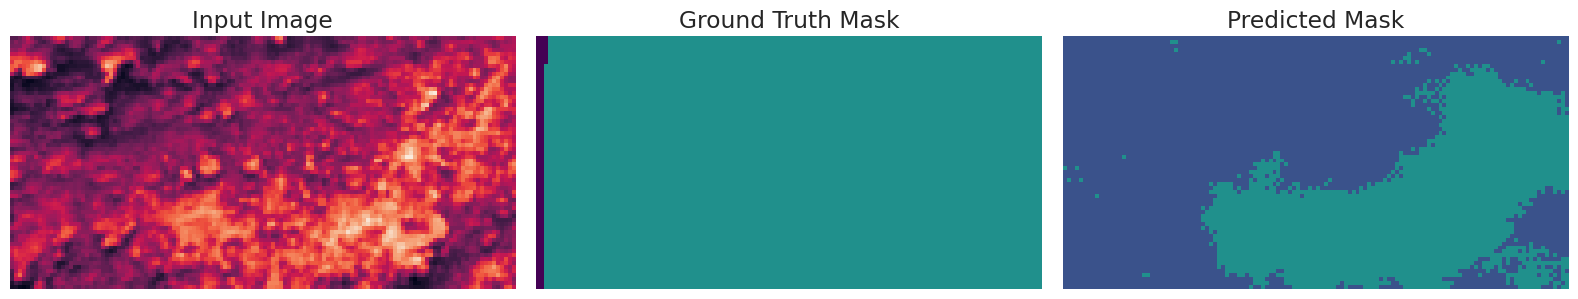

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0064 - mean_iou: 0.7812 - val_loss: 0.0403 - val_mean_iou: 0.6419 - learning_rate: 5.0000e-04
Epoch 112/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0058 - mean_iou: 0.7982 - val_loss: 0.0424 - val_mean_iou: 0.6509 - learning_rate: 5.0000e-04
Epoch 113/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0052 - mean_iou: 0.8252 - val_loss: 0.0437 - val_mean_iou: 0.6372 - learning_rate: 5.0000e-04
Epoch 114/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0057 - mean_iou: 0.7947 - val_loss: 0.0525 - val_mean_iou: 0.6544 - learning_rate: 5.0000e-04
Epoch 115/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0046 - mean_iou: 0.8446 - val_loss: 0.0572 - val_mean_iou: 0.6593 - learning_rate: 5.0000e-04
Epoch 116/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0042 - mean_iou: 0.8685

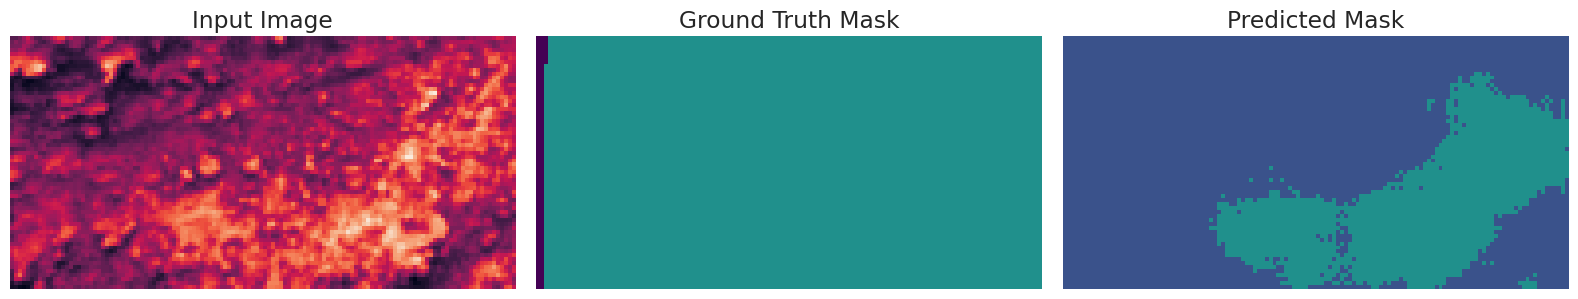


Epoch 116: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0042 - mean_iou: 0.8684 - val_loss: 0.0557 - val_mean_iou: 0.6699 - learning_rate: 5.0000e-04
Epoch 117/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0040 - mean_iou: 0.8699 - val_loss: 0.0526 - val_mean_iou: 0.6194 - learning_rate: 2.5000e-04
Epoch 118/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0043 - mean_iou: 0.8664 - val_loss: 0.0508 - val_mean_iou: 0.6376 - learning_rate: 2.5000e-04
Epoch 119/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0040 - mean_iou: 0.8769 - val_loss: 0.0518 - val_mean_iou: 0.6400 - learning_rate: 2.5000e-04
Epoch 120/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0037 - mean_iou: 0.8846 - val_loss: 0.0524 - val_mean_iou: 0.6272 - learning_rate: 2.5000e-04
Epoch 121/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0036 - mean_iou: 0.8843

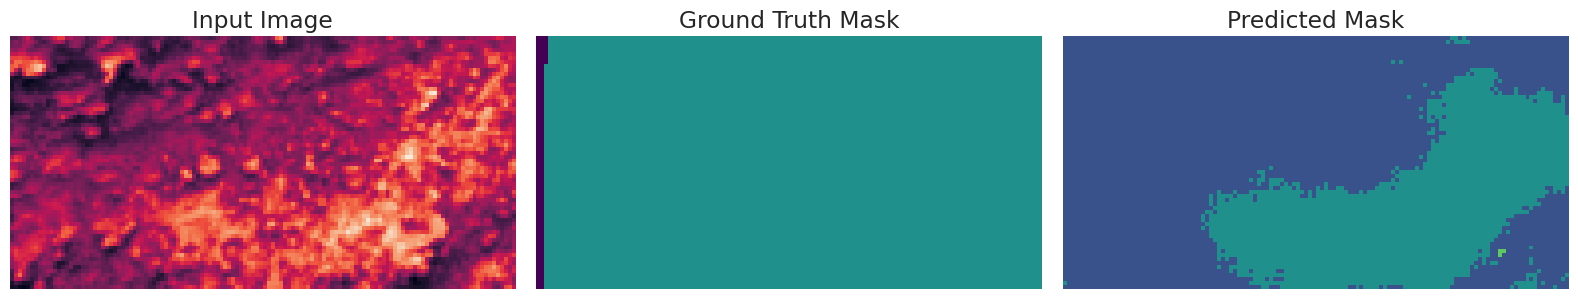

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0036 - mean_iou: 0.8844 - val_loss: 0.0519 - val_mean_iou: 0.6535 - learning_rate: 2.5000e-04
Epoch 122/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0034 - mean_iou: 0.8934 - val_loss: 0.0565 - val_mean_iou: 0.6378 - learning_rate: 2.5000e-04
Epoch 123/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0034 - mean_iou: 0.8995 - val_loss: 0.0558 - val_mean_iou: 0.6437 - learning_rate: 2.5000e-04
Epoch 124/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0033 - mean_iou: 0.8960 - val_loss: 0.0616 - val_mean_iou: 0.6268 - learning_rate: 2.5000e-04
Epoch 125/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0034 - mean_iou: 0.9006 - val_loss: 0.0627 - val_mean_iou: 0.6235 - learning_rate: 2.5000e-04
Epoch 126/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0032 - mean_iou: 0.9032

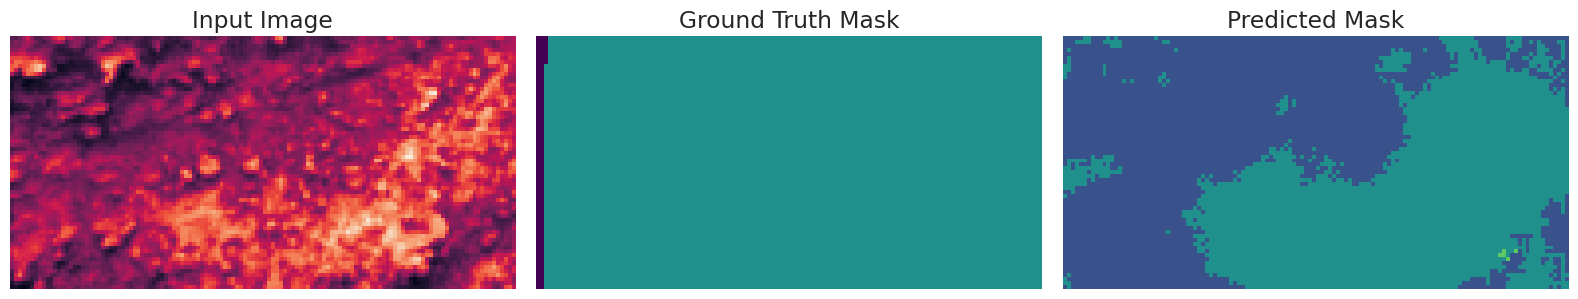


Epoch 126: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0032 - mean_iou: 0.9033 - val_loss: 0.0596 - val_mean_iou: 0.6522 - learning_rate: 2.5000e-04
Epoch 127/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0032 - mean_iou: 0.9048 - val_loss: 0.0582 - val_mean_iou: 0.6674 - learning_rate: 1.2500e-04
Epoch 128/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0030 - mean_iou: 0.9043 - val_loss: 0.0591 - val_mean_iou: 0.6610 - learning_rate: 1.2500e-04
Epoch 129/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0029 - mean_iou: 0.9039 - val_loss: 0.0606 - val_mean_iou: 0.6644 - learning_rate: 1.2500e-04
Epoch 130/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0029 - mean_iou: 0.9061 - val_loss: 0.0622 - val_mean_iou: 0.6628 - learning_rate: 1.2500e-04
Epoch 131/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0029 - mean_iou: 0.9112

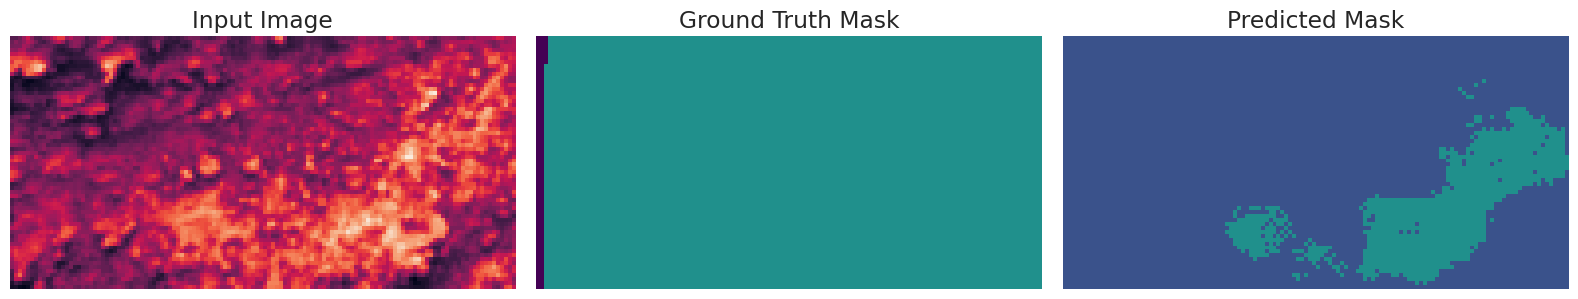

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0029 - mean_iou: 0.9114 - val_loss: 0.0630 - val_mean_iou: 0.6637 - learning_rate: 1.2500e-04
Epoch 132/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0028 - mean_iou: 0.9176 - val_loss: 0.0655 - val_mean_iou: 0.6665 - learning_rate: 1.2500e-04
Epoch 133/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0028 - mean_iou: 0.9210 - val_loss: 0.0655 - val_mean_iou: 0.6646 - learning_rate: 1.2500e-04
Epoch 134/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0027 - mean_iou: 0.9214 - val_loss: 0.0679 - val_mean_iou: 0.6555 - learning_rate: 1.2500e-04
Epoch 135/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0027 - mean_iou: 0.9254 - val_loss: 0.0684 - val_mean_iou: 0.6665 - learning_rate: 1.2500e-04
Epoch 136/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0026 - mean_iou: 0.9256

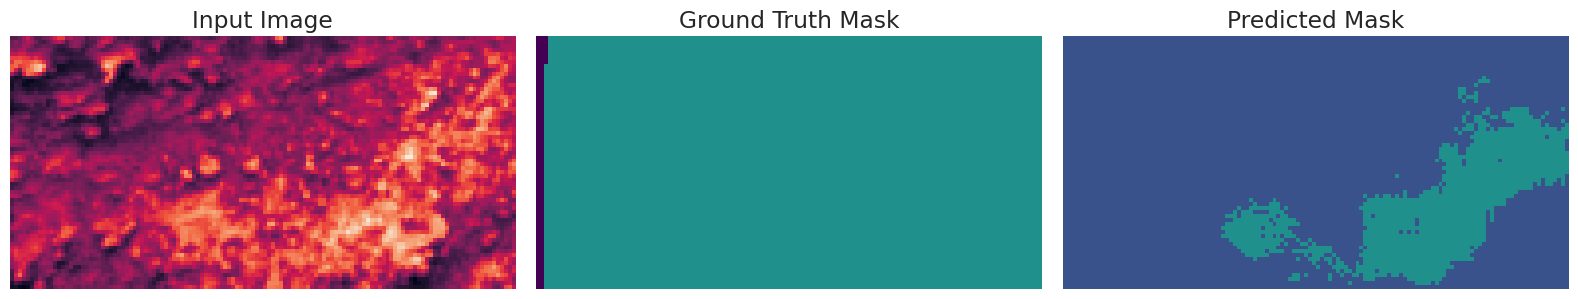


Epoch 136: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0026 - mean_iou: 0.9257 - val_loss: 0.0690 - val_mean_iou: 0.6666 - learning_rate: 1.2500e-04
Final validation Mean Intersection Over Union: 68.29%


In [22]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

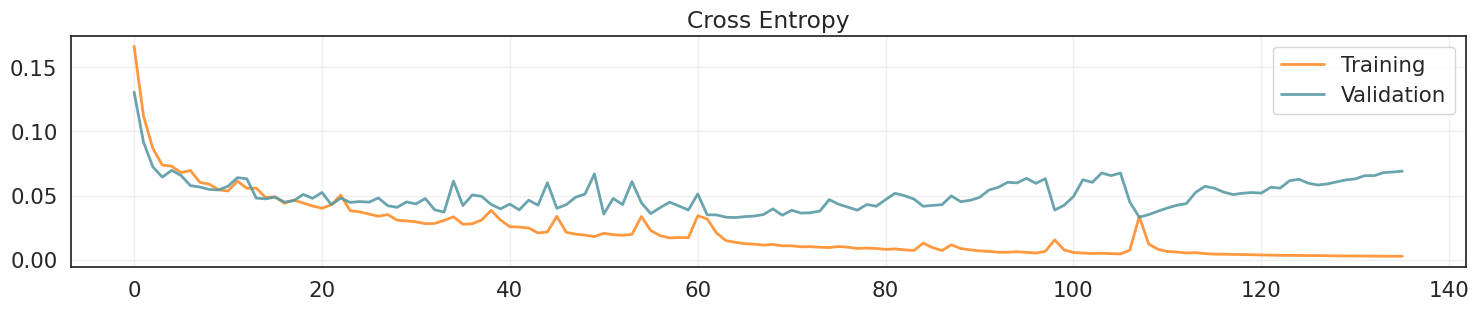

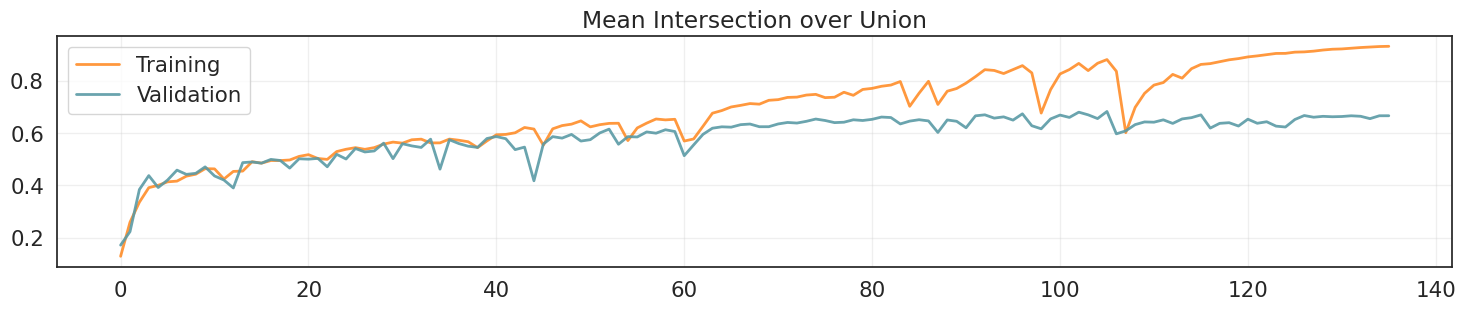

In [23]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
#Get prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step
Predictions shape: (10022, 64, 128)


In [25]:
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [26]:
submission_filename = f"CustomUNetFocalCw.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)